In [1]:
import sys  
sys.path.insert(0, '../')

In [2]:
import os
import numpy as np
import GPyOpt
from feature_extraction.loan_struct_reader import LoanStructReader
from feature_extraction.loan_options_maker import LoanOptionsMaker
from feature_extraction.loan_concatenator import LoanConcatenator
from feature_extraction.loan_markuper import LoanMarkuper
from feature_extraction.hist_market_worker import HistMarketDataWorker

from scipy.stats.contingency import margins
import matplotlib.pyplot as plt
import scipy.stats as ss
import math

warning in stationary: failed to import cython module: falling back to numpy
warning in coregionalize: failed to import cython module: falling back to numpy
warning in choleskies: failed to import cython module: falling back to numpy


In [3]:
plt.rcParams["axes.labelsize"] = 16. 
plt.rcParams["xtick.labelsize"] = 14. 
plt.rcParams["ytick.labelsize"] = 14. 
plt.rcParams["legend.fontsize"] = 12. 
plt.rcParams["figure.figsize"] = [15., 6.]

In [4]:
PROJECT_PATH = os.path.dirname(os.getcwd())
DOMAIN = [{'name': 'var_1', 'type': 'continuous', 'domain': (0, 2)},
          {'name': 'var_2', 'type': 'continuous', 'domain': (0, 2)},
          {'name': 'var_3', 'type': 'continuous', 'domain': (0, 2)},
          {'name': 'var_4', 'type': 'continuous', 'domain': (0, 2)},
          {'name': 'var_5', 'type': 'continuous', 'domain': (0, 2)},
          {'name': 'var_6', 'type': 'continuous', 'domain': (0, 2)},
          {'name': 'var_7', 'type': 'continuous', 'domain': (0, 2)},
          {'name': 'var_8', 'type': 'continuous', 'domain': (0, 2)},
          {'name': 'var_9', 'type': 'continuous', 'domain': (0, 2)},
          {'name': 'var_10', 'type': 'continuous', 'domain': (0, 2)}]

DOMAIN_1 = {'name': 'var_1', 'type': 'continuous', 'domain':(0, 1), 'dimensionality':10}

DOMAIN_2 = [{'name': 'var_1', 'type': 'continuous', 'domain': (0, 2)}, 
            {'name': 'var_2', 'type': 'continuous', 'domain': (0, 2)}]

In [5]:
def f(X, json_example_path=os.path.join(PROJECT_PATH, r"json_real", r"sample_1.json")):
    "It should take 2-dimensional numpy arrays as input and return 2-dimensional outputs (one evaluation per row)"
    Y = []
    for x in X:
        struct, original_options = LoanStructReader().Read(json_example_path, returnOptions=True)
        options = LoanOptionsMaker().Make(original_options, ir_curve=x)

        loan = LoanConcatenator(struct, options, {}).Parse()
        Y.append([LoanMarkuper().MarkupLoan(loan)])
    return np.array(Y)/1000

### На малых размерностях $\mu$ не обнуляется

In [6]:
def f1(X):
    return f(np.concatenate((X[:, :2], np.ones((X.shape[0], 8))), axis = 1))

-----------
### Test on empirical observations

In [7]:
mu = np.array([0.999791,  0.99853703,  0.99374632,  0.98132504,  0.96271221,
        0.92621573,  0.85829915,  0.67985138,  0.4574298,  0.45154276])
cov = np.cov(np.random.rand(10,10))

In [8]:
hmdw = HistMarketDataWorker().load()

In [9]:
normal_dist_1 = ss.multivariate_normal(mean=hmdw.get_func().mean, cov=hmdw.get_func().cov, allow_singular=True)
normal_dist_2 = ss.multivariate_normal(mean=hmdw.get_func().mean, cov=cov, allow_singular=True)
rho_foo_1 = lambda X: np.array([[normal_dist_1.pdf(x)] for x in X])

In [10]:
hmdw.get_func().cov

array([[  1.68364856e-11,   1.17855399e-10,   4.84730408e-10,
          1.43678159e-09,   2.75599180e-09,   5.31215103e-09,
          1.00413010e-08,   2.14812457e-08,   2.90042984e-08,
          2.92104868e-08],
       [  1.17855399e-10,   8.24987793e-10,   3.39311286e-09,
          1.00574711e-08,   1.92919426e-08,   3.71850572e-08,
          7.02891071e-08,   1.50368720e-07,   2.03030089e-07,
          2.04473407e-07],
       [  4.84730408e-10,   3.39311286e-09,   1.46573849e-08,
          4.23008916e-08,   7.81069061e-08,   1.42614838e-07,
          2.57516001e-07,   5.75501836e-07,   8.67940396e-07,
          8.75678783e-07],
       [  1.43678159e-09,   1.00574711e-08,   4.23008916e-08,
          1.41398817e-07,   3.08534936e-07,   6.61392309e-07,
          1.24699012e-06,   2.08307409e-06,   1.92202021e-06,
          1.91585845e-06],
       [  2.75599180e-09,   1.92919426e-08,   7.81069061e-08,
          3.08534936e-07,   8.09740663e-07,   2.00397555e-06,
          4.02922430e-06

---------

In [11]:
X_init = np.array(np.ones(HistMarketDataWorker().load().get_sample().shape).reshape(1, -1))#[:,:2]
print(X_init.shape)
Y_init = f(X_init)
print(Y_init)

bo = GPyOpt.methods.BayesianOptimization(f=f1, domain=DOMAIN,
                                        initial_design_numdata = 5,
                                        X=X_init, Y=Y_init,
                                        acquisition_type='LCB',
                                        exact_feval = True,
                                        normalize_Y = False,
                                        optimize_restarts = 10,
                                        acquisition_weight = 2,
                                        de_duplication = True)
                                        #rho_func = rho_foo_1, #hmdw.rho_normal,
                                        #exploration_weight=1000,
                                        #with_noise=False)

X_test = []
for i in range(20):
    X_test.append(hmdw.get_sample())
X_test = np.array(X_test)

bo.run_optimization(18)#, test_X = X_test)
print('evaluations_list: ', bo.get_evaluations())

print('test_sample_values:')
predict = bo.model.predict(X_test)
print('\mu_values: ', predict[0])
print('\sigma_values: ', predict[1])
print('MAE: ', np.mean(predict[1] / predict[0]))
#print('MAE_list: ', bo.error_list)

(1, 10)
[[100000.]]
optimization_running...
step:  0
variance:  [  4.99999990e+09]
variance:  [  4.99998990e+09]
variance:  [  4.99998990e+09]
variance:  [  4.99998990e+09]
variance:  [  1.66038010e+09]
variance:  [  8.68611077e+08]
variance:  [  4.37370451e+08]
variance:  [  2.40845992e+08]
variance:  [  1.34381519e+08]
variance:  [ 76322759.10846025]
variance:  [ 43432881.45186245]
variance:  [ 24753496.66846164]
variance:  [ 14104348.01632082]
variance:  [ 8037480.4194357]
variance:  [ 4580024.30460373]
variance:  [ 2609894.63356511]
variance:  [ 1487220.43018451]
variance:  [ 847478.71128429]
variance:  [ 482927.38587538]
variance:  [ 275191.51012029]
variance:  [ 156815.2037673]
variance:  [ 89359.6225369]
variance:  [ 50920.71288089]
variance:  [ 29016.67381294]
variance:  [ 16534.86976071]
variance:  [ 9422.23494312]
variance:  [ 5369.16905882]
variance:  [ 3059.56882709]
variance:  [ 1743.4655666]
variance:  [ 993.49690761]
variance:  [ 566.13455319]
variance:  [ 322.60626816]


step:  1
variance:  [  5.68601198e-06]
variance:  [  5.68601198e-06]
variance:  [  5.68377510e-06]
variance:  [  5.68377510e-06]
variance:  [  5.68377510e-06]
variance:  [  2.00310437e+10]
variance:  [  2.00310437e+10]
variance:  [  4.84603845e+09]
variance:  [  2.30626085e+09]
variance:  [  1.03085659e+09]
variance:  [  5.32705914e+08]
variance:  [  2.85297314e+08]
variance:  [  1.59124914e+08]
variance:  [ 89953038.98989211]
variance:  [ 51199749.72807956]
variance:  [ 29168966.84408747]
variance:  [ 16622529.40982362]
variance:  [ 9472105.39219567]
variance:  [ 5397629.38091922]
variance:  [ 3075778.72497498]
variance:  [ 1752703.05393082]
variance:  [ 998759.85520502]
variance:  [ 569133.40129896]
variance:  [ 324315.00455884]
variance:  [ 184807.70829508]
variance:  [ 105310.85537074]
variance:  [ 60010.35941657]
variance:  [ 34196.31596819]
variance:  [ 19486.44083408]
variance:  [ 11104.40026371]
variance:  [ 6040.16397482]
variance:  [ 3536.02849563]
variance:  [ 1994.02242825]

step:  2
variance:  [  1.13840197e-05]
variance:  [  1.13840197e-05]
variance:  [  1.11659219e-05]
variance:  [  1.35508133e-05]
variance:  [  9.65078761e-06]
variance:  [  9.58220273e-06]
variance:  [  9.57653147e-06]
variance:  [  1.21829741e-05]
variance:  [  9.57653673e-06]
variance:  [  9.57653668e-06]
variance:  [  9.57653668e-06]
variance:  [  9.57653668e-06]
variance:  [  2.32821318e+10]
variance:  [  2.32821318e+10]
variance:  [  6.32347934e+09]
variance:  [  3.13740502e+09]
variance:  [  1.47436095e+09]
variance:  [  7.84316938e+08]
variance:  [  4.28188086e+08]
variance:  [  2.41082903e+08]
variance:  [  1.36800188e+08]
variance:  [ 77933433.79374647]
variance:  [ 44402976.842223]
variance:  [ 25302116.03309194]
variance:  [ 14407558.0081871]
variance:  [ 6796106.39379031]
variance:  [ 4903508.53221474]
variance:  [ 1330572.71510429]
variance:  [ 987157.59392135]
variance:  [ 600559.04009126]
variance:  [ 438791.21367119]
variance:  [ 253124.88023508]
variance:  [ 147968.149

step:  3
variance:  [  2.93176097e-06]
variance:  [  2.93176097e-06]
variance:  [  3.16029439e-06]
variance:  [  2.93111335e-06]
variance:  [  2.93105058e-06]
variance:  [  2.93105070e-06]
variance:  [  2.93105070e-06]
variance:  [  2.93105070e-06]
variance:  [  5.63942304e+09]
variance:  [  5.63942304e+09]
variance:  [  2.08728782e+09]
variance:  [  1.11544405e+09]
variance:  [  5.79363823e+08]
variance:  [  3.22283081e+08]
variance:  [  1.81216885e+08]
variance:  [  1.02929279e+08]
variance:  [ 61324893.09350001]
variance:  [ 31237977.23678001]
variance:  [ 19796775.21200255]
variance:  [ 10973093.84232751]
variance:  [ 6315428.04289029]
variance:  [ 3585387.81496604]
variance:  [ 2046081.3991919]
variance:  [ 1165052.71886031]
variance:  [ 661795.50359219]
variance:  [ 381060.54623994]
variance:  [ 238473.92488011]
variance:  [ 141061.48305256]
variance:  [ 99966.43343767]
variance:  [ 68189.56608957]
variance:  [ 46598.82653116]
variance:  [ 31786.73401953]
variance:  [ 17222.39013

variance:  [  1.40966671e+09]
variance:  [  7.35214643e+08]
variance:  [  4.00768147e+08]
variance:  [  2.24675551e+08]
variance:  [  1.27448228e+08]
variance:  [ 72551038.00634764]
variance:  [ 44481509.17749126]
variance:  [ 21467469.08003252]
variance:  [ 16001322.28389877]
variance:  [ 11363287.99609524]
variance:  [ 8080073.38680129]
variance:  [ 5953680.00310246]
variance:  [ 3055539.72846629]
variance:  [ 1812361.30909901]
variance:  [ 1018550.05882568]
variance:  [ 584246.89213909]
variance:  [ 332009.68124529]
variance:  [ 192610.30164994]
variance:  [ 125559.50748878]
variance:  [ 72757.13034787]
variance:  [ 50200.08542277]
variance:  [ 69025.23379943]
variance:  [ 40161.17206994]
variance:  [ 27368.59417562]
variance:  [ 14731.67775578]
variance:  [ 8579.39851947]
variance:  [ 4848.1338742]
variance:  [ 2771.63352587]
variance:  [ 1577.43184937]
variance:  [ 899.3123907]
variance:  [ 512.37259949]
variance:  [ 292.22676725]
variance:  [ 168.17894942]
variance:  [ 2249.19289

step:  5
variance:  [  3.01536289e-06]
variance:  [  3.01536289e-06]
variance:  [  3.17188845e-06]
variance:  [  3.00333869e-06]
variance:  [  3.00280231e-06]
variance:  [  3.00280364e-06]
variance:  [  3.00280364e-06]
variance:  [  3.00280364e-06]
variance:  [  6.15516437e+10]
variance:  [  6.15516437e+10]
variance:  [  1.37065169e+10]
variance:  [  6.29369785e+09]
variance:  [  2.69583071e+09]
variance:  [  1.35648415e+09]
variance:  [  7.13375640e+08]
variance:  [  3.94012944e+08]
variance:  [  2.21756305e+08]
variance:  [  1.26050920e+08]
variance:  [ 71793834.30412069]
variance:  [ 40911513.33439764]
variance:  [ 23311892.43418719]
variance:  [ 13280253.01075231]
variance:  [ 7088008.25876217]
variance:  [ 9748317.24193429]
variance:  [ 4493869.48453131]
variance:  [ 3893297.01273667]
variance:  [ 3803791.11735752]
variance:  [ 3331082.91421111]
variance:  [ 2504324.00541157]
variance:  [ 1454310.08696456]
variance:  [ 828645.31591685]
variance:  [ 564929.69705484]
variance:  [ 30

step:  6
variance:  [  3.00510448e-06]
variance:  [  3.00510448e-06]
variance:  [  3.32691466e-06]
variance:  [  3.00519235e-06]
variance:  [  3.00519490e-06]
variance:  [  3.00519490e-06]
variance:  [  3.00519490e-06]
variance:  [  2.19509098e+10]
variance:  [  2.19509098e+10]
variance:  [  6.04155903e+09]
variance:  [  3.01020332e+09]
variance:  [  1.42192551e+09]
variance:  [  7.58568346e+08]
variance:  [  4.14889114e+08]
variance:  [  2.33788800e+08]
variance:  [  1.32701539e+08]
variance:  [ 75603231.43832542]
variance:  [ 43076174.99926928]
variance:  [ 24547458.68051015]
variance:  [ 13987925.40254168]
variance:  [ 7970928.5366077]
variance:  [ 4542146.34947738]
variance:  [ 2588300.15966205]
variance:  [ 1474917.23758839]
variance:  [ 840467.36942395]
variance:  [ 478932.14554326]
variance:  [ 272914.83669946]
variance:  [ 155517.86773552]
variance:  [ 88620.34639389]
variance:  [ 50499.44327945]
variance:  [ 28776.61697556]
variance:  [ 16398.07541447]
variance:  [ 9344.283775

step:  7
variance:  [  2.99841946e-06]
variance:  [  2.99841946e-06]
variance:  [  3.32117997e-06]
variance:  [  2.99897239e-06]
variance:  [  2.99898943e-06]
variance:  [  2.99898943e-06]
variance:  [  2.99898943e-06]
variance:  [  8.31517254e+10]
variance:  [  8.31517254e+10]
variance:  [  1.72320773e+10]
variance:  [  7.65475873e+09]
variance:  [  3.13747433e+09]
variance:  [  1.53315529e+09]
variance:  [  7.89470611e+08]
variance:  [  4.30558445e+08]
variance:  [  2.40789792e+08]
variance:  [  1.36580779e+08]
variance:  [ 77727340.45704846]
variance:  [ 50120473.54366633]
variance:  [ 27721028.57190283]
variance:  [ 17436806.84772656]
variance:  [ 10543756.92615021]
variance:  [ 6056370.48046509]
variance:  [ 3441634.89952368]
variance:  [ 1969020.66186234]
variance:  [ 1125365.77548694]
variance:  [ 641256.27022834]
variance:  [ 365555.16495515]
variance:  [ 208020.01012113]
variance:  [ 116464.45109289]
variance:  [ 59305.12920104]
variance:  [ 33208.44794876]
variance:  [ 40037.

step:  8
variance:  [  3.00203674e-06]
variance:  [  3.00203674e-06]
variance:  [  3.20453478e-06]
variance:  [  3.00183701e-06]
variance:  [  3.00180009e-06]
variance:  [  3.00180009e-06]
variance:  [  3.00180009e-06]
variance:  [  1.15911919e+10]
variance:  [  1.15911919e+10]
variance:  [  3.71095432e+09]
variance:  [  1.92594014e+09]
variance:  [  9.58915697e+08]
variance:  [  5.25365792e+08]
variance:  [  2.92212196e+08]
variance:  [  1.65785560e+08]
variance:  [ 94311914.48518798]
variance:  [ 53744273.28474645]
variance:  [ 30595452.26320839]
variance:  [ 15740049.78075211]
variance:  [ 28251904.93561025]
variance:  [ 11794426.62274375]
variance:  [ 10400201.92459938]
variance:  [ 9169117.26156492]
variance:  [ 7539050.40287994]
variance:  [ 3775341.03707738]
variance:  [ 2255971.57344555]
variance:  [ 1270815.53473495]
variance:  [ 727070.53820529]
variance:  [ 413455.79663361]
variance:  [ 236077.14496472]
variance:  [ 135423.7363939]
variance:  [ 76964.81379538]
variance:  [ 4

step:  9
variance:  [  3.00796336e-06]
variance:  [  3.00796336e-06]
variance:  [  3.20010083e-06]
variance:  [  3.00753891e-06]
variance:  [  3.00746377e-06]
variance:  [  3.00746375e-06]
variance:  [  3.00746375e-06]
variance:  [  3.00746375e-06]
variance:  [  3.84174951e+11]
variance:  [  3.84174951e+11]
variance:  [  6.59307536e+10]
variance:  [  2.59316176e+10]
variance:  [  9.08860562e+09]
variance:  [  3.93885183e+09]
variance:  [  1.83802404e+09]
variance:  [  9.14377082e+08]
variance:  [  4.55618685e+08]
variance:  [  2.81938479e+08]
variance:  [  1.48015133e+08]
variance:  [ 83909500.03684703]
variance:  [ 46649519.84057814]
variance:  [ 26430874.83991259]
variance:  [ 14858145.53582693]
variance:  [ 8398208.61242228]
variance:  [ 4771810.83991908]
variance:  [ 2702168.28824113]
variance:  [ 1595107.53408251]
variance:  [ 896422.90105497]
variance:  [ 509804.6529868]
variance:  [ 279883.665021]
variance:  [ 208105.67980117]
variance:  [ 106288.23145389]
variance:  [ 63099.312

variance:  [  1.05828792e-09]
variance:  [  1.05755239e+10]
variance:  [  1.05755239e+10]
variance:  [  3.44462883e+09]
variance:  [  1.78199054e+09]
variance:  [  8.63106028e+08]
variance:  [  4.47816605e+08]
variance:  [  2.70136655e+08]
variance:  [  1.44820709e+08]
variance:  [ 80665125.47199994]
variance:  [ 45353509.08382931]
variance:  [ 25907208.93658013]
variance:  [ 14716282.62378809]
variance:  [ 8253519.0465268]
variance:  [ 4742863.12608391]
variance:  [ 2679346.00291332]
variance:  [ 1497852.00111504]
variance:  [ 954408.16267562]
variance:  [ 1269565.19120357]
variance:  [ 852745.69160543]
variance:  [ 486166.80025351]
variance:  [ 278714.03634165]
variance:  [ 158491.26371077]
variance:  [ 90404.46618801]
variance:  [ 51504.04747831]
variance:  [ 29354.27947197]
variance:  [ 16726.25928562]
variance:  [ 9531.49449255]
variance:  [ 5431.44100552]
variance:  [ 3095.08431705]
variance:  [ 1414.50027237]
variance:  [ 845.93181532]
variance:  [ 473.05861306]
variance:  [ 473

step:  11
variance:  [  1.17250273e-09]
variance:  [  1.17250273e-09]
variance:  [  4.06966806e-10]
variance:  [  9.36093252e-10]
variance:  [  9.34322187e-10]
variance:  [  9.34342712e-10]
variance:  [  9.34342712e-10]
variance:  [  9.34342712e-10]
variance:  [  5.22182399e+10]
variance:  [  5.22182399e+10]
variance:  [  1.17929112e+10]
variance:  [  5.46047424e+09]
variance:  [  2.35454845e+09]
variance:  [  1.19020463e+09]
variance:  [  6.27802269e+08]
variance:  [  3.46860461e+08]
variance:  [  1.95361257e+08]
variance:  [  1.10973060e+08]
variance:  [ 64719537.91760568]
variance:  [ 29851525.8906997]
variance:  [ 20125270.77258659]
variance:  [ 10687759.94639443]
variance:  [ 6345837.56623406]
variance:  [ 3586994.66925592]
variance:  [ 2049127.34371011]
variance:  [ 1194487.70892874]
variance:  [ 845781.45220456]
variance:  [ 563309.25417547]
variance:  [ 359130.66813179]
variance:  [ 227864.46091472]
variance:  [ 125367.49030985]
variance:  [ 72285.75378147]
variance:  [ 62424.4

step:  12
variance:  [  7.97027027e-10]
variance:  [  7.97027027e-10]
variance:  [  1.67974700e-09]
variance:  [  1.03765780e-09]
variance:  [  1.03754651e-09]
variance:  [  1.03754651e-09]
variance:  [  1.03754651e-09]
variance:  [  2.18986057e+10]
variance:  [  2.18986057e+10]
variance:  [  5.91907687e+09]
variance:  [  2.93373512e+09]
variance:  [  1.37495280e+09]
variance:  [  7.31104395e+08]
variance:  [  3.98327616e+08]
variance:  [  2.24027159e+08]
variance:  [  1.27121143e+08]
variance:  [ 72422085.21952714]
variance:  [ 47498887.4322291]
variance:  [ 27390252.91218161]
variance:  [ 18283615.93229305]
variance:  [ 12250100.61372046]
variance:  [ 6834345.90046096]
variance:  [ 3914973.41125788]
variance:  [ 2294572.49540979]
variance:  [ 1306649.95102899]
variance:  [ 747877.30107076]
variance:  [ 448040.60490302]
variance:  [ 246080.75517921]
variance:  [ 152525.49074373]
variance:  [ 83444.90781911]
variance:  [ 50884.88145736]
variance:  [ 26129.50791761]
variance:  [ 15480.7

step:  13
variance:  [  8.58480780e-10]
variance:  [  8.58480780e-10]
variance:  [  1.78532766e-09]
variance:  [  1.16778772e-09]
variance:  [  1.16769248e-09]
variance:  [  1.16769248e-09]
variance:  [  1.16769248e-09]
variance:  [  1.49455032e+10]
variance:  [  1.49455032e+10]
variance:  [  4.49173868e+09]
variance:  [  2.29315620e+09]
variance:  [  1.11312885e+09]
variance:  [  5.90169412e+08]
variance:  [  2.91885252e+08]
variance:  [  1.85311884e+08]
variance:  [ 93506820.85580167]
variance:  [ 54596000.54757342]
variance:  [ 30819915.05973691]
variance:  [ 17615820.50772052]
variance:  [ 9898271.18195271]
variance:  [ 5740288.05857975]
variance:  [ 3240977.177642]
variance:  [ 1855633.1752229]
variance:  [ 1046171.44547865]
variance:  [ 596093.95045913]
variance:  [ 335824.37262828]
variance:  [ 17257939.87029678]
variance:  [ 331962.76516582]
variance:  [ 190113.39697833]
variance:  [ 108421.3576458]
variance:  [ 61763.76376053]
variance:  [ 35199.91510259]
variance:  [ 20057.53

step:  14
variance:  [  1.01174349e-09]
variance:  [  1.01174349e-09]
variance:  [  1.99623761e-09]
variance:  [  1.29832339e-09]
variance:  [  1.29820511e-09]
variance:  [  1.29820511e-09]
variance:  [  1.29820511e-09]
variance:  [  3.88475581e+10]
variance:  [  3.88475581e+10]
variance:  [  9.43915086e+09]
variance:  [  4.49713298e+09]
variance:  [  2.00744486e+09]
variance:  [  1.02556921e+09]
variance:  [  5.19961784e+08]
variance:  [  2.89201587e+08]
variance:  [  1.75468151e+08]
variance:  [ 96795535.54262236]
variance:  [ 55806751.12966373]
variance:  [ 31521783.91577244]
variance:  [ 18071534.54341558]
variance:  [ 11013606.80066239]
variance:  [ 6117289.10955861]
variance:  [ 3564368.11196615]
variance:  [ 2004532.3421337]
variance:  [ 1158287.66138004]
variance:  [ 648101.32319975]
variance:  [ 43391772.56185306]
variance:  [ 639660.63643281]
variance:  [ 367381.26377032]
variance:  [ 208890.91489694]
variance:  [ 119150.17537558]
variance:  [ 67873.1984818]
variance:  [ 3868

step:  15
variance:  [  1.12071252e-09]
variance:  [  1.12071252e-09]
variance:  [  2.15210824e-09]
variance:  [  1.48909115e-09]
variance:  [  1.48900193e-09]
variance:  [  1.48900193e-09]
variance:  [  1.48900193e-09]
variance:  [  1.44904678e+11]
variance:  [  1.44904678e+11]
variance:  [  2.80573385e+10]
variance:  [  1.19646345e+10]
variance:  [  4.67975526e+09]
variance:  [  2.21271385e+09]
variance:  [  1.11272344e+09]
variance:  [  5.98493477e+08]
variance:  [  3.32275417e+08]
variance:  [  1.87889288e+08]
variance:  [  1.06876904e+08]
variance:  [ 60894561.16921166]
variance:  [ 34699275.88579239]
variance:  [ 19773175.90194416]
variance:  [ 11267523.0402491]
variance:  [ 6420694.94343026]
variance:  [ 3658769.20196146]
variance:  [ 2084914.33458217]
variance:  [ 1188068.01257618]
variance:  [ 677008.81707777]
variance:  [ 385785.90623829]
variance:  [ 219588.43268277]
variance:  [ 9633972.90780589]
variance:  [ 216945.19618123]
variance:  [ 209890.68478477]
variance:  [ 40170

step:  16
variance:  [  1.31226579e-09]
variance:  [  1.31226579e-09]
variance:  [  2.40074599e-09]
variance:  [  1.66629472e-09]
variance:  [  1.66618239e-09]
variance:  [  1.66618239e-09]
variance:  [  1.66618239e-09]
variance:  [  4.06860193e+10]
variance:  [  4.06860193e+10]
variance:  [  9.81093856e+09]
variance:  [  4.66298086e+09]
variance:  [  2.08106035e+09]
variance:  [  1.07442813e+09]
variance:  [  5.75085529e+08]
variance:  [  3.20666484e+08]
variance:  [  1.81253398e+08]
variance:  [  1.03162328e+08]
variance:  [ 58770793.22394224]
variance:  [ 33491119.3691219]
variance:  [ 19084285.22494074]
variance:  [ 10875060.85578668]
variance:  [ 6197033.30110355]
variance:  [ 3531322.43124813]
variance:  [ 2012289.0934959]
variance:  [ 1146683.54816608]
variance:  [ 653426.44742765]
variance:  [ 372348.71990448]
variance:  [ 212179.29788691]
variance:  [ 120908.31051739]
variance:  [ 68898.42449346]
variance:  [ 39261.09572717]
variance:  [ 22372.54171616]
variance:  [ 11702.5548

variance:  [ 7.51003052]
variance:  [ 4.27949946]
variance:  [ 2.43862128]
variance:  [ 1.38961627]
variance:  [ 1.38961627]
variance:  [ 1.38961627]
variance:  [ 1.38961627]
variance:  [  9.19036232e+10]
variance:  [  9.19036232e+10]
variance:  [  1.90868912e+10]
variance:  [  8.46658046e+09]
variance:  [  3.47822141e+09]
variance:  [  1.70231052e+09]
variance:  [  8.77843317e+08]
variance:  [  4.79345306e+08]
variance:  [  2.68109689e+08]
variance:  [  1.51350485e+08]
variance:  [ 76918466.28597413]
variance:  [ 88594152.30049077]
variance:  [ 65299588.54900492]
variance:  [ 53583245.02949662]
variance:  [ 26626087.86878635]
variance:  [ 16048942.46493298]
variance:  [ 8972282.15537137]
variance:  [ 5160222.5110479]
variance:  [ 2933184.22725999]
variance:  [ 1673561.6471596]
variance:  [ 953136.54082412]
variance:  [ 543243.18440288]
variance:  [ 309500.6003108]
variance:  [ 5312668.08557913]
variance:  [ 308571.41623982]
variance:  [ 175956.58571741]
variance:  [ 100268.4052589]
va

step:  17
variance:  [  1.48657334e-09]
variance:  [  1.48657334e-09]
variance:  [  2.62678046e-09]
variance:  [  1.87544589e-09]
variance:  [  1.87533814e-09]
variance:  [  1.87533814e-09]
variance:  [  1.87533814e-09]
variance:  [  7.82817299e+09]
variance:  [  7.82817299e+09]
variance:  [  2.76392538e+09]
variance:  [  1.46299385e+09]
variance:  [  7.49753227e+08]
variance:  [  4.15710035e+08]
variance:  [  2.32165709e+08]
variance:  [  1.25014148e+08]
variance:  [ 89492000.86769156]
variance:  [ 81829847.86613558]
variance:  [ 66505086.97345322]
variance:  [ 34574344.92386231]
variance:  [ 20666931.37089901]
variance:  [ 11604201.86523242]
variance:  [ 6662251.99762809]
variance:  [ 3788199.44956773]
variance:  [ 2160660.09491143]
variance:  [ 1230633.69419629]
variance:  [ 701382.21104308]
variance:  [ 399626.57353725]
variance:  [ 229816.27295505]
variance:  [ 86441.99592491]
variance:  [ 60704.82329951]
variance:  [ 31780.36580746]
variance:  [ 18697.01041647]
variance:  [ 10523

step:  18
variance:  [  1.69799822e-09]
variance:  [  1.69799822e-09]
variance:  [  2.89225225e-09]
variance:  [  2.07789207e-09]
variance:  [  2.07776820e-09]
variance:  [  2.07776820e-09]
variance:  [  2.07776820e-09]
variance:  [  7.66069378e+09]
variance:  [  7.66069378e+09]
variance:  [  2.67432094e+09]
variance:  [  1.40717291e+09]
variance:  [  7.19216726e+08]
variance:  [  3.99707903e+08]
variance:  [  2.22670224e+08]
variance:  [  1.26837466e+08]
variance:  [ 68326077.79519667]
variance:  [ 37694897.25168777]
variance:  [ 22626977.85496177]
variance:  [ 14266356.28690507]
variance:  [ 7805445.87228663]
variance:  [ 4523410.3242018]
variance:  [ 2559293.82410992]
variance:  [ 1462358.46184193]
variance:  [ 831642.0323021]
variance:  [ 475631.0974513]
variance:  [ 308611.64568516]
variance:  [ 22001349.20111835]
variance:  [ 297834.02522534]
variance:  [ 161438.29630444]
variance:  [ 93600.13084075]
variance:  [ 53030.46813357]
variance:  [ 30285.90915274]
variance:  [ 17243.450

In [12]:
X_test[0]

array([ 0.99979   ,  0.99853001,  0.99374179,  0.9811724 ,  0.96210082,
        0.92407917,  0.85574636,  0.67502077,  0.45838138,  0.45276679])

In [13]:
bo.model.predict(X_test[0])

(array([[ 114704.6372835]]), array([[ 5441.28365296]]))

-----------
### Check statistics from X_test

In [14]:
X_test = []
for i in range(20000):
    X_test.append(hmdw.get_sample())
X_test = np.array(X_test)

In [15]:
X_test

array([[ 0.99979216,  0.99854513,  0.99375912, ...,  0.67933234,
         0.44337376,  0.43703739],
       [ 0.99979332,  0.99855326,  0.99379877, ...,  0.68846262,
         0.47221814,  0.46659297],
       [ 0.99978685,  0.99850798,  0.99359321, ...,  0.67568777,
         0.45453427,  0.44840936],
       ..., 
       [ 0.99979306,  0.99855145,  0.99381596, ...,  0.67571569,
         0.45371672,  0.4476139 ],
       [ 0.9997916 ,  0.99854123,  0.99373869, ...,  0.6834177 ,
         0.45481212,  0.44884008],
       [ 0.99978861,  0.99852025,  0.99366064, ...,  0.68843989,
         0.45161151,  0.44531562]])

In [16]:
mean_values = np.mean(np.transpose(X_test), 1)
mean_values

array([ 0.999791  ,  0.99853703,  0.99374632,  0.98132504,  0.96271221,
        0.92621573,  0.85829915,  0.67985138,  0.4574298 ,  0.45154276])

In [17]:
np.std(np.transpose(X_test), 1)

array([  4.08725409e-06,   2.86107792e-05,   1.20669247e-04,
         3.75176684e-04,   9.02358560e-04,   2.35545598e-03,
         5.14899681e-03,   8.13050804e-03,   9.45530094e-03,
         9.63005707e-03])

------------

In [18]:
a1 = bo.error_list[1:]
b1 = bo.test_error_list[1:]

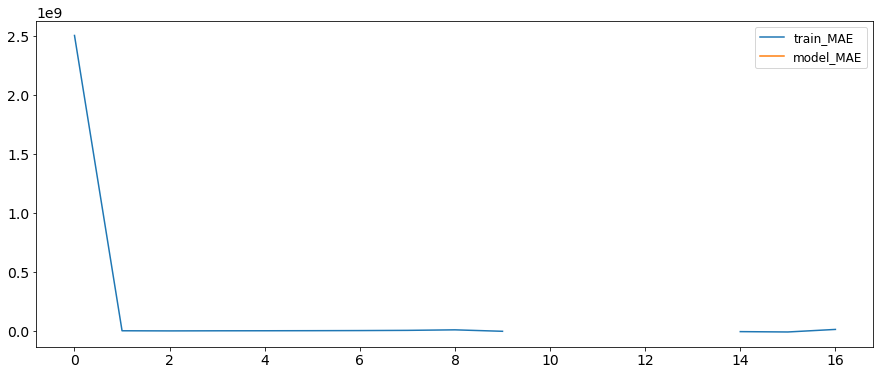

In [19]:
plt.plot(a1, label = 'train_MAE')
plt.plot(b1, label = 'model_MAE')
#plt.plot([np.mean(predict[1] / predict[0]) for _ in range(len(bo.error_list)-1)], color = 'red', label = 'test_MAE')
plt.legend()
plt.show()

In [20]:
plt.plot(np.diff(bo.test_error_list[1:])[20:])
print('maximum_diff: ', max(np.diff(bo.test_error_list[1:])[20:]))
plt.show()

ValueError: max() arg is an empty sequence

In [ ]:
np.std(np.transpose(X_test)[0])

In [ ]:
rho = lambda x: ss.norm.pdf(x, loc = np.mean(np.transpose(X_test)[0]), scale = np.sqrt(hmdw.get_func().cov[0][0]))

x = np.linspace(0.9997, 0.9999, 10000)
plt.plot(x, rho(x), 'k-', lw=2, label='frozen pdf')
plt.hist(np.transpose(X_test)[0], bins = 30, normed = True)
plt.grid()
plt.title('first argument distribution')
plt.show()

In [ ]:
rho = lambda x: ss.norm.pdf(x, loc = np.mean(np.transpose(X_test)[1]), scale = np.sqrt(hmdw.get_func().cov[1][1]))

x = np.linspace(0.9984, 0.9988, 10000)
plt.plot(x, rho(x), 'k-', lw=2, label='frozen pdf')
plt.hist(np.transpose(X_test)[1], bins = 30, normed = True)
plt.grid()
plt.title('first argument distribution')
plt.show()

In [ ]:
rho = lambda x: ss.norm.pdf(x, loc = np.mean(np.transpose(X_test)[-1]), scale = np.sqrt(hmdw.get_func().cov[-1][-1]))

x = np.linspace(0.4, 0.5, 10000)
plt.plot(x, rho(x), 'k-', lw=2, label='frozen pdf')
plt.hist(np.transpose(X_test)[-1], bins = 30, normed = True)
plt.grid()
plt.title('last argument distribution')
plt.show()

In [ ]:
hmdw.get_func().cov[0][0]*1e7

### Check data on test points
---------------

In [ ]:
vals = bo.get_evaluations()
X = vals[0]
y = [k[0] for k in vals[1]]

In [ ]:
plt.hist(X.T[0], bins = 40, label = "First_argument")
plt.axvline(mean_values[0], color = 'red', label = 'mean_test_value')
plt.legend()
plt.show()

In [ ]:
plt.hist(X.T[1], bins = 40, label = "Second_argument")
plt.axvline(mean_values[1], color = 'red', label = 'mean_test_value')
plt.legend()
plt.show()

In [ ]:
plt.hist(X.T[2], bins = 40, label = "Third_argument")
plt.axvline(mean_values[2], color = 'red', label = 'mean_test_value')
plt.legend()
plt.show()

In [ ]:
plt.hist(X.T[3], bins = 40, label = "Fourth_argument")
plt.axvline(mean_values[3], color = 'red', label = 'mean_test_value')
plt.legend()
plt.show()

In [ ]:
plt.hist(X.T[-1], bins = 40, label = "Last_argument")
plt.axvline(mean_values[-1], color = 'red', label = 'mean_test_value')
plt.legend()
plt.show()

----------
### Lets look at the histogram of the avaliable values relative to the theoretical distribution for the model covariance matrix

In [ ]:
plt.plot(np.arange(0,1, 0.0001), np.array(bo.sigma_arr)[2])
plt.title('sigma_array')
plt.show()

--------------
#### Get sigma arrays

In [ ]:
for k in range(10):
    plt.plot(np.arange(0,1, 0.0001), np.array(bo.sigma_arr)[k], label = 'sigma_'+str(k))
plt.title('sigma_arrays')
plt.legend()
plt.show()

-------------

In [ ]:
get_prob_arr = lambda k: ss.norm.pdf(x = np.linspace(0,1,10000), loc = hmdw.get_func().mean[k], scale = np.sqrt(hmdw.get_func().cov[k][k]))
marginal_dist = margins(np.array([get_prob_arr(i) for i in range(10)]))[1]

In [ ]:
rho_arr = ss.norm.pdf(x = np.arange(0,1,0.0001), loc = hmdw.get_func().mean[-1], scale = np.sqrt(hmdw.get_func().cov[-1][-1]))
arr = np.array([np.arange(0,1,0.0001) for _ in range(10)])
mass = rho_foo_1(arr.T)

In [ ]:
for k in range(np.array(bo.sigma_arr).shape[0]):
    plt.plot(np.arange(0,1,0.0001), np.array(bo.sigma_arr)[k].reshape(-1)*rho_arr)
    plt.axvline(X.T[0][1:][k])
    plt.show()

In [ ]:
bo.sigma_arr

In [ ]:
for k in range(np.array(bo.sigma_arr).shape[0]):
    plt.plot(np.arange(0,1,0.0001), np.array(bo.sigma_arr)[k].reshape(-1)*rho_arr)
    plt.axvline(X.T[0][1:][k], color = 'green', alpha = 0.2, linewidth = 0.5)
plt.show()

In [ ]:
plt.plot(np.arange(0,1,0.0001), rho_arr)
plt.hist(X.T[0], bins = 40, label = "First_argument", normed = True)
plt.show()

In [ ]:
plt.plot(np.linspace(0,1,10000), marginal_dist[0])
plt.title('marginal distribution')
plt.show()

In [ ]:
# get covariance matrix (diagonal)
np.diag(hmdw.get_func().cov)

In [ ]:
# get mean values
hmdw.get_func().mean

In [ ]:
plt.plot(np.linspace(0.,1.,10000), np.array([get_prob_arr(i) for i in range(10)])[0])
plt.show()

In [ ]:
#plt.plot(np.linspace(0,1,10000), marginal_dist[0])
plt.hist(np.sum(X.T, 0)/max(np.sum(X.T, 0)), normed = True, bins = 20)
plt.title('Is it legal?')
plt.show()

In [ ]:
np.array([np.arange(0,1,0.0001) for _ in range(10)]).T

In [ ]:
variance = 151072.43839228
exp= np.eye(18)
val = np.matrix([[0.00000000e+000,-3.54705491e+302,-3.54705491e+302,-1.63086605e+302
   -3.54705491e+302,-3.54705491e+302,-3.54705491e+302,-3.45153532e+302
   -3.46848828e+302  -3.49803721e+302  -3.50690490e+302  -3.52741191e+302
   -3.54705491e+302  -3.54705491e+302  -1.91942829e+302  -3.21958249e+302
   -3.46880386e+302  -1.41558976e+302]
 [ -3.54705491e+302   0.00000000e+000  -1.41882197e+303  -9.15605089e+302
   -9.93175376e+302  -9.93175376e+302  -1.13505757e+303  -9.93923057e+302
   -9.93666530e+302  -9.93357544e+302  -9.93295918e+302  -9.93203351e+302
   -9.93175376e+302  -9.93175376e+302  -7.75258617e+302  -1.01171246e+303
   -9.93662332e+302  -3.68996884e+302]
 [ -3.54705491e+302  -1.41882197e+303   0.00000000e+000  -1.19979105e+302
   -4.25646590e+302  -4.25646590e+302  -2.83764393e+302  -4.05794991e+302
   -4.09442109e+302  -4.15660881e+302  -4.17496044e+302  -4.21690014e+302
   -4.25646590e+302  -4.25646590e+302  -3.18038023e+302  -3.41615022e+302
   -4.09509422e+302  -6.23532051e+302]
 [ -1.63086605e+302  -9.15605089e+302  -1.19979105e+302   0.00000000e+000
   -4.67281391e+302  -4.72951828e+302  -3.68010168e+302  -4.55781849e+302
   -4.53583980e+302  -4.64289776e+302  -4.60372858e+302  -4.69513962e+302
   -4.32891444e+302  -4.54783285e+302  -2.98916785e+302  -3.67026121e+302
   -4.58978794e+302  -3.83361315e+302]
 [ -3.54705491e+302  -9.93175376e+302  -4.25646590e+302  -4.67281391e+302
    0.00000000e+000  -2.83764393e+302  -1.41882197e+302  -2.63912794e+302
   -4.91154361e+299  -2.73778684e+302  -1.20541698e+299  -2.79807817e+302
   -5.67528786e+302  -5.67528786e+302  -3.10889314e+302  -4.83497218e+302
   -2.67627226e+302  -6.56258445e+302]
 [ -3.54705491e+302  -9.93175376e+302  -4.25646590e+302  -4.72951828e+302
   -2.83764393e+302   0.00000000e+000  -1.41882197e+302  -7.47680716e+299
   -2.67559912e+302  -1.82168248e+299  -2.75613848e+302  -2.79750521e+298
   -2.83764393e+302  -5.67528786e+302  -2.04329406e+302  -1.99732825e+302
   -4.86955876e+299  -5.44091796e+302]
 [ -3.54705491e+302  -1.13505757e+303  -2.83764393e+302  -3.68010168e+302
   -1.41882197e+302  -1.41882197e+302   0.00000000e+000  -1.22030597e+302
   -1.25677716e+302  -1.31896488e+302  -1.33731651e+302  -1.37925621e+302
   -4.25646590e+302  -4.25646590e+302  -3.00727276e+302  -3.41615022e+302
   -1.25745029e+302  -6.85907195e+302]
 [ -3.45153532e+302  -9.93923057e+302  -4.05794991e+302  -4.55781849e+302
   -2.63912794e+302  -7.47680716e+299  -1.22030597e+302   0.00000000e+000
   -2.47708313e+302  -1.91733293e+299  -2.55762249e+302  -4.86405655e+299
   -2.84512074e+302  -5.47677187e+302  -2.01775248e+302  -2.00480506e+302
   -2.78432907e+298  -5.44834628e+302]
 [ -3.46848828e+302  -9.93666530e+302  -4.09442109e+302  -4.53583980e+302
   -4.91154361e+299  -2.67559912e+302  -1.25677716e+302  -2.47708313e+302
    0.00000000e+000  -2.57574203e+302  -1.25056230e+299  -2.63603336e+302
   -5.51324305e+302  -5.51324305e+302  -3.02434754e+302  -4.67292737e+302
   -2.51422745e+302  -6.50146203e+302]
 [ -3.49803721e+302  -9.93357544e+302  -4.15660881e+302  -4.64289776e+302
   -2.73778684e+302  -1.82168248e+299  -1.31896488e+302  -1.91733293e+299
   -2.57574203e+302   0.00000000e+000  -2.65628139e+302  -6.73684248e+298
   -2.83946561e+302  -5.57543077e+302  -2.02881775e+302  -1.99914994e+302
   -7.34466989e+298  -5.44271571e+302]
 [ -3.50690490e+302  -9.93295918e+302  -4.17496044e+302  -4.60372858e+302
   -1.20541698e+299  -2.75613848e+302  -1.33731651e+302  -2.55762249e+302
   -1.25056230e+299  -2.65628139e+302   0.00000000e+000  -2.71657272e+302
   -5.59378241e+302  -5.59378241e+302  -3.06578112e+302  -4.75346673e+302
   -2.59476680e+302  -6.53107637e+302]
 [ -3.52741191e+302  -9.93203351e+302  -4.21690014e+302  -4.69513962e+302
   -2.79807817e+302  -2.79750521e+298  -1.37925621e+302  -4.86405655e+299
   -2.63603336e+302  -6.73684248e+298  -2.71657272e+302   0.00000000e+000
   -2.83792368e+302  -5.63572210e+302  -2.03718701e+302  -1.99760800e+302
   -2.81499002e+299  -5.44118833e+302]
 [ -3.54705491e+302  -9.93175376e+302  -4.25646590e+302  -4.32891444e+302
   -5.67528786e+302  -2.83764393e+302  -4.25646590e+302  -2.84512074e+302
   -5.51324305e+302  -2.83946561e+302  -5.59378241e+302  -2.83792368e+302
    0.00000000e+000  -8.51293179e+302  -1.25791909e+302  -1.85370828e+301
   -2.84251349e+302  -4.79085386e+302]
 [ -3.54705491e+302  -9.93175376e+302  -4.25646590e+302  -4.54783285e+302
   -5.67528786e+302  -5.67528786e+302  -4.25646590e+302  -5.47677187e+302
   -5.51324305e+302  -5.57543077e+302  -5.59378241e+302  -5.63572210e+302
   -8.51293179e+302   0.00000000e+000  -5.74845052e+302  -7.67261612e+302
   -5.51391619e+302  -4.64547913e+302]
 [ -1.91942829e+302  -7.75258617e+302  -3.18038023e+302  -2.98916785e+302
   -3.10889314e+302  -2.04329406e+302  -3.00727276e+302  -2.01775248e+302
   -3.02434754e+302  -2.02881775e+302  -3.06578112e+302  -2.03718701e+302
   -1.25791909e+302  -5.74845052e+302   0.00000000e+000  -8.01128978e+301
   -2.02151697e+302  -2.54014082e+302]
 [ -3.21958249e+302  -1.01171246e+303  -3.41615022e+302  -3.67026121e+302
   -4.83497218e+302  -1.99732825e+302  -3.41615022e+302  -2.00480506e+302
   -4.67292737e+302  -1.99914994e+302  -4.75346673e+302  -1.99760800e+302
   -1.85370828e+301  -7.67261612e+302  -8.01128978e+301   0.00000000e+000
   -2.00219781e+302  -4.31865028e+302]
 [ -3.46880386e+302  -9.93662332e+302  -4.09509422e+302  -4.58978794e+302
   -2.67627226e+302  -4.86955876e+299  -1.25745029e+302  -2.78432907e+298
   -2.51422745e+302  -7.34466989e+298  -2.59476680e+302  -2.81499002e+299
   -2.84251349e+302  -5.51391619e+302  -2.02151697e+302  -2.00219781e+302
    0.00000000e+000  -5.44574839e+302]
 [ -1.41558976e+302  -3.68996884e+302  -6.23532051e+302  -3.83361315e+302
   -6.56258445e+302  -5.44091796e+302  -6.85907195e+302  -5.44834628e+302
   -6.50146203e+302  -5.44271571e+302  -6.53107637e+302  -5.44118833e+302
   -4.79085386e+302  -4.64547913e+302  -2.54014082e+302  -4.31865028e+302
   -5.44574839e+302   0.00000000e+000]])

In [ ]:
val= np.array([[-3.68996884e+30  -6.23532051e+302  -3.83361315e+302], 
               [-3.68996884e+302  -6.23532051e+303  -3.83361315e+302],
               [-3.68996884e+302  -6.23532051e+302  -3.83361315e+302]])
exp = np.eye(3)
variance = 151072.43839228

In [ ]:
variance*val*exp

In [ ]:
arr = variance*val
arr = np.where(arr == -np.inf, 0, arr)
arr = arr*exp
arr

In [ ]:
np.where(arr == -np.inf, 0, arr)

In [ ]:
k = np.array([1,2,3])
np.where(k==2, 0, np.where(k==3, 0, k))

In [ ]:
variance*val*exp